# Reward and Error Learning Simulation (Izawa & Shadmehr, 2011)

## 1. Imports and Constants

In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [115]:
# Simulation settings
total_trials = 200
gamma = 0.95          # discount factor
alpha_r = 0.04         # learning rate for reward prediction error
alpha_v = 0.15         # learning rate for value function
a = 0.9              # forgetting factor for perturbation

# Noise terms
s_h = 3
s_y_by_condition = {
    "ERR": 6.0,
    "EPE": 15.0,
    "RWD": 1e6  # essentially no observation
}
s_phat = 3
s_u = 1.25

target_radius = 3
beta = 0.001 # Scaling parameter for motor cost





In [116]:
# Create perturbation array p
step_size = -1         # Size of each step change
start_value = 0        # Starting value
baseline_trials = 0   # Number of trials for each level
step_length = 40
num_steps = 9          # Number of steps (including baseline)
plateau_length = 140    # Length of final plateau

# Calculate total trials needed
total_trials = baseline_trials + (step_length * num_steps) + plateau_length

# Initialize array
p = np.zeros(total_trials)

# Fill with pattern: baseline_trials of start_value, baseline_trials of start_value+step_size, etc.
p[0:baseline_trials] = start_value
last_trial = baseline_trials
for i in range(num_steps):
    step_end = last_trial + step_length
    p[last_trial:step_end] = start_value + (i * step_size)
    last_trial = step_end

# Add plateau at the end
p[last_trial:total_trials] = start_value + (num_steps-1) * step_size

Text(0, 0.5, 'Perturbation Value')

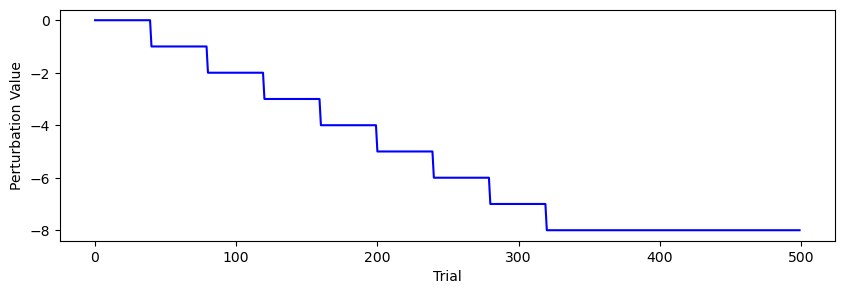

In [117]:
plt.figure(figsize=(10, 3))
plt.plot(p, label='Perturbation p', color='blue')
plt.xlabel('Trial')
plt.ylabel('Perturbation Value')

## 2. Task Environment Setup

In [118]:
def simulate(s_y, p, seed=42,  
             s_h=s_h, s_phat=s_phat, s_u=s_u, beta=beta, 
             A=a, 
             gamma=gamma, alpha_v=alpha_v, alpha_r=alpha_r, target_radius=target_radius):
    # Define system matrices (example values - adjust according to your paper)
    b = np.array([[0], [1]])  # input matrix
    C = np.array([[1, 1]])    # observation matrix
    A = np.array([[a, 0], [1, 0]])

    C = np.array([[1, 1]])            # 1x2 observation matrix
    Q = np.diag([s_phat**2, s_h**2])  # 2x2 process noise covariance

    total_trials = len(p)

    np.random.seed(seed)
    R = np.array([[s_y**2]])  # 1x1 observation noise covariance

    # Initialize variables with proper dimensions (+1 for k+1 terms)
    x = np.zeros((2, total_trials))        # True state [p; h]
    u = np.zeros(total_trials + 1)         # Motor command (k+1 needed)
    x_hat = np.zeros((2, total_trials + 1))# State estimate (k+1)
    P = np.zeros((2, 2, total_trials))     # Covariance (k only)
    K = np.zeros((2, 1, total_trials))     # Kalman gain (k only)
    
    # Observation/reward terms (k only)
    c = np.zeros(total_trials)
    y = np.zeros(total_trials)
    r = np.zeros(total_trials)
    delta = np.zeros(total_trials)
    
    # Noise terms (k only)
    n_h = np.random.normal(0, s_h, total_trials)
    n_y = np.random.normal(0, s_y, total_trials)
    n_p = np.random.normal(0, s_phat, total_trials)
    n_u = np.random.normal(0, s_u, total_trials)
    
    # Learning weights (k+1 needed)
    w_r = np.zeros(total_trials + 1)
    w_v = np.zeros(total_trials + 1)

    # Main simulation loop
    for k in range(total_trials):
        # =====================================================================
        # 1. True System Dynamics
        # =====================================================================
        # p[k] is predefined perturbation (e.g., rotation schedule)
        x[0, k] = p[k]                            # True perturbation
        x[1, k] = u[k] + n_h[k]                   # True hand position
        
        # =====================================================================
        # 2. Observation Model
        # =====================================================================
        c[k] = (C @ x[:, k])[0]                    # Cursor position (scalar)
        y[k] = c[k] + n_y[k]                      # Noisy observation (scalar)
        
        # =====================================================================
        # 3. Kalman Filter Update
        # =====================================================================
        if k == 0:
            x_hat_prev = x_hat[:, 0]
            P_prev = Q             # Initial covariance
        else:
            x_hat_prev = x_hat[:, k]
            P_prev = P[:, :, k-1]
        
        # Predict step
        x_hat_pred = A @ x_hat_prev + b * u[k]    # (2,) vector predict
        P_pred = A @ P_prev @ A.T + Q             # (2x2)
        
        S = C @ P_pred @ C.T + R
        K_k = P_pred @ C.T @ np.linalg.inv(S)
        K[:, :, k] = K_k

        residual = y[k] - (C @ x_hat_pred)[0]
        x_hat[:, k+1] = x_hat_pred + (K_k.flatten() * residual)
        P[:, :, k] = (np.eye(2) - K_k @ C) @ P_pred
        
        # =====================================================================
        # 4. Reward and Learning Updates
        # =====================================================================
        effort = beta * u[k] ** 2
        r[k] = 1 - effort if abs(c[k]) < target_radius else -effort
        
        if k > 0:
            # Temporal Difference Error
            delta[k] = r[k] + gamma * w_v[k] - w_v[k-1]
            
            # Update value and policy weights
            w_v[k+1] = w_v[k] + alpha_v * delta[k]
            w_r[k+1] = w_r[k] + alpha_r * delta[k] * n_u[k]
        else:
            # Initialize for k=0
            delta[0] = 0
            w_v[1] = w_v[0]
            w_r[1] = w_r[0]
        
        # =====================================================================
        # 5. Next Motor Command
        # =====================================================================
        u[k+1] = -x_hat[0, k] + w_r[k] + n_u[k]   # (scalar)
        u[k+1] = np.clip(u[k+1], -90, 90)

    # =====================================================================
    # 6. Compile Results (Trim k+1 variables to match trial count)
    # =====================================================================
    return pd.DataFrame({
        'trial': np.arange(total_trials),
        # True System
        'x_p': x[0, :],              # True perturbation
        'x_h': x[1, :],              # True hand position
        'c': c,                      # Cursor position
        'y': y,                      # Noisy observation
        # Estimates
        'x_hat_p': x_hat[0, :total_trials],  # Trim last element
        'x_hat_h': x_hat[1, :total_trials],
        # Motor Command
        'u': u[:total_trials],       # Trim last element
        # Learning Variables
        'w_r': w_r[:total_trials],
        'w_v': w_v[:total_trials],
        'r': r,
        'delta': delta,
        # Noise Terms
        'n_h': n_h,
        'n_y': n_y,
        'n_p': n_p,
        'n_u': n_u,
        # Covariance/Gain Terms
        'P_00': P[0, 0, :],
        'P_11': P[1, 1, :],
        'K_0': K[0, 0, :],
        'K_1': K[1, 0, :]
    })

## 3. Run Simulation for Each Condition

In [119]:
condition = 'ERR'
s_y = s_y_by_condition[condition]
err_df = simulate(s_y, p)

ValueError: could not broadcast input array from shape (2,2) into shape (2,)

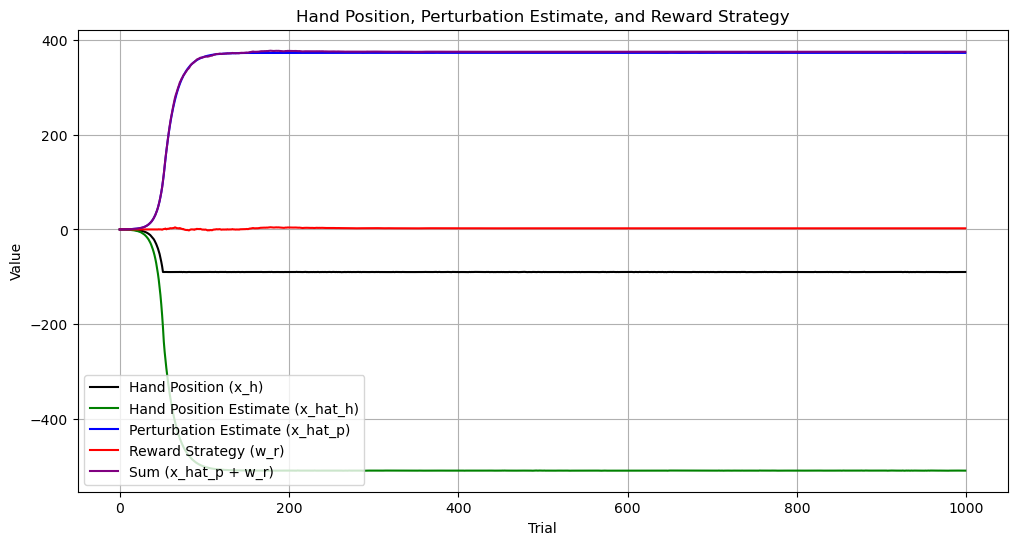

In [ ]:
plt.figure(figsize=(12, 6))

# Plot components with specified colors
plt.plot(err_df['trial'], err_df['x_h'], 'k-', label='Hand Position (x_h)')
plt.plot(err_df['trial'], err_df['x_hat_h'], 'g', label='Hand Position Estimate (x_hat_h)')
plt.plot(err_df['trial'], err_df['x_hat_p'], 'b-', label='Perturbation Estimate (x_hat_p)')
plt.plot(err_df['trial'], err_df['w_r'], 'r-', label='Reward Strategy (w_r)')
plt.plot(err_df['trial'], err_df['x_hat_p'] + err_df['w_r'], 'purple', label='Sum (x_hat_p + w_r)')

# Add labels and legend
plt.xlabel('Trial')
plt.ylabel('Value')
plt.title('Hand Position, Perturbation Estimate, and Reward Strategy')
plt.legend()
plt.grid(True)
plt.show()

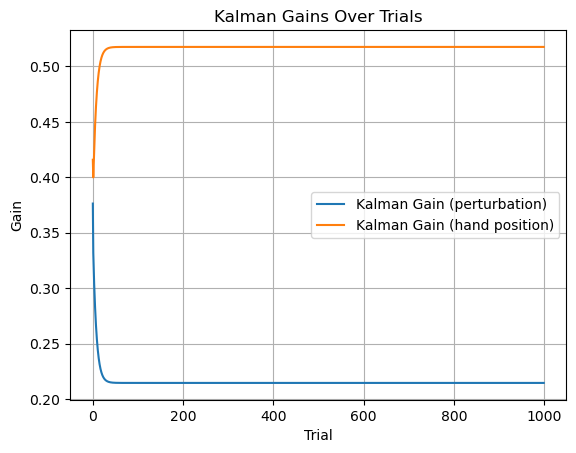

In [ ]:
plt.plot(err_df['K_0'], label='Kalman Gain (perturbation)')
plt.plot(err_df['K_1'], label='Kalman Gain (hand position)')
plt.title("Kalman Gains Over Trials")
plt.xlabel("Trial")
plt.ylabel("Gain")
plt.legend()
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Observation Residual')

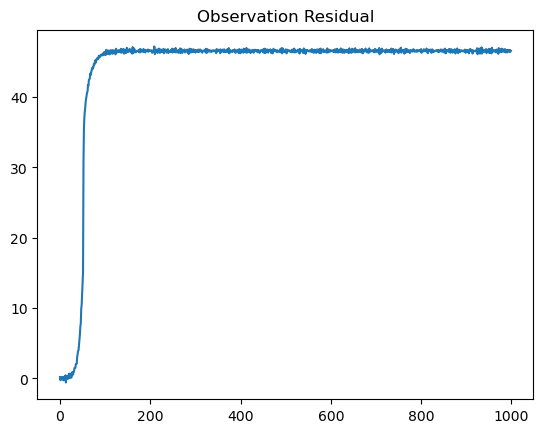

In [ ]:
resid = err_df['y'] - (err_df['x_hat_p'] + err_df['x_hat_h'])
plt.plot(resid)
plt.title("Observation Residual")